In [1]:
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 93.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 57.1 MB/s eta 0:00:00


In [82]:
from underthesea import word_tokenize

sentence = "Với cộng đồng người Bách Việt trước đây, việc thuần hóa mèo cũng có thể theo cách thức như vậy."
print(word_tokenize(sentence))

['Với', 'cộng đồng', 'người', 'Bách Việt', 'trước đây', ',', 'việc', 'thuần hóa', 'mèo', 'cũng', 'có thể', 'theo', 'cách thức', 'như vậy', '.']


In [2]:
import torch
def load_word_embeddings(file_path, embedding_dim=100, unk_init=torch.Tensor.normal_):
    word_embeddings = {}
    skipped_lines = 0

    with open(file_path, 'r', encoding='utf-8') as f:
        for line in f:
            parts = line.strip().split()
            if len(parts) != embedding_dim + 1:
                skipped_lines += 1
                continue  # Bỏ qua dòng không hợp lệ
            try:
                word = parts[0]
                vector = torch.tensor(list(map(float, parts[1:])), dtype=torch.float)
                word_embeddings[word] = vector
            except ValueError:
                skipped_lines += 1
                continue  # Bỏ qua nếu không thể chuyển đổi thành float

    # Tạo ma trận embedding
    vocab_size = len(word_embeddings)
    embedding_matrix = torch.empty(vocab_size, embedding_dim)

    for i, (word, vector) in enumerate(word_embeddings.items()):
        embedding_matrix[i] = vector

    return word_embeddings, embedding_matrix



In [3]:
# Đường dẫn tới file vi_word2vec.txt
file_path = "/kaggle/input/dataset/vi_word2vec.txt"

# Gọi hàm để tải embeddings
word_embeddings, embedding_matrix = load_word_embeddings(file_path, embedding_dim=100)

# Kiểm tra kích thước của ma trận embedding
print(embedding_matrix.shape)  # >> torch.Size([số từ hợp lệ, 100])

torch.Size([1585076, 100])


## Sử dụng pretrain để tạo bộ vocab

In [4]:
from itertools import chain
from collections import Counter

import torch
from tqdm import tqdm
from underthesea import word_tokenize


class Vocabulary:
    """ The Vocabulary class is used to record words, which are used to convert 
        text to numbers and vice versa.
    """

    def __init__(self):
        self.word2id = dict()
        self.word2id['<pad>'] = 0   # Pad Token
        self.word2id['<unk>'] = 1   # Unknown Token
        self.unk_id = self.word2id['<unk>']
        self.id2word = {v: k for k, v in self.word2id.items()}

    def __getitem__(self, word):
        return self.word2id.get(word, self.unk_id)

    def __contains__(self, word):
        return word in self.word2id 
    
    def __len__(self):
        return len(self.word2id)

    def id2word(self, word_index):
        """
        @param word_index (int)
        @return word (str)
        """
        return self.id2word[word_index]

    def add(self, word):
        """ Add word to vocabulary
        @param word (str)
        @return index (str): index of the word just added
        """
        if word not in self:
            word_index = self.word2id[word] = len(self.word2id)
            self.id2word[word_index] = word
            return word_index
        else:
            return self[word]

    @staticmethod
    def tokenize_corpus(corpus):
        """Split the documents of the corpus into words
        @param corpus (list(str)): list of documents
        @return tokenized_corpus (list(list(str))): list of words
        """
        print("Tokenize the corpus...")
        tokenized_corpus = list()
        for document in tqdm(corpus):
            tokenized_document = [word.replace(" ", "_") for word in word_tokenize(document)]
            tokenized_corpus.append(tokenized_document)

        return tokenized_corpus

    def corpus_to_tensor(self, corpus, is_tokenized=False):
        """ Convert corpus to a list of indices tensor
        @param corpus (list(str) if is_tokenized==False else list(list(str)))
        @param is_tokenized (bool)
        @return indicies_corpus (list(tensor))
        """
        if is_tokenized:
            tokenized_corpus = corpus
        else:
            tokenized_corpus = self.tokenize_corpus(corpus)
        indicies_corpus = list()
        for document in tqdm(tokenized_corpus):
            indicies_document = torch.tensor(list(map(lambda word: self[word], document)),
                                             dtype=torch.int64)
            indicies_corpus.append(indicies_document)

        return indicies_corpus

    def tensor_to_corpus(self, tensor):
        """ Convert list of indices tensor to a list of tokenized documents
        @param indicies_corpus (list(tensor))
        @return corpus (list(list(str)))
        """
        corpus = list()
        for indicies in tqdm(tensor):
            document = list(map(lambda index: self.id2word[index.item()], indicies))
            corpus.append(document)

        return corpus


In [5]:
vocab = Vocabulary()
# create vocabulary from pretrained word2vec
words_list = list(word_embeddings.keys())
for word in words_list:
    vocab.add(word)

In [6]:
len(vocab)

1585078

## Load Data

In [7]:
from scipy.linalg import dft
import pandas as pd
import torch
from torch.utils.data import Dataset


class LoadDataset(Dataset):
    """ Load dataset from file csv"""

    def __init__(self, vocab, csv_fpath=None, tokenized_fpath=None):
        """
        @param vocab (Vocabulary)
        @param csv_fpath (str)
        @param tokenized_fpath (str)
        """
        self.vocab = vocab
        self.pad_idx = vocab["<pad>"]
        df = pd.read_csv(csv_fpath)
        self.sentiments_list = list(df.sentiment)
        self.reviews_list = list(df.vi_review)

        sentiments_type = list(set(self.sentiments_list))
        sentiments_type.sort()

        self.sentiment2id = {sentiment: i for i, sentiment in enumerate(sentiments_type)}

        if tokenized_fpath:
            self.tokenized_reviews = torch.load(tokenized_fpath)
        else:
            self.tokenized_reviews = self.vocab.tokenize_corpus(self.reviews_list)

        self.tensor_data = self.vocab.corpus_to_tensor(self.tokenized_reviews, is_tokenized=True)
        self.tensor_label = torch.tensor([self.sentiment2id[sentiment] for sentiment in self.sentiments_list],
                                         dtype=torch.float64)

    def __len__(self):
        return len(self.tensor_data)

    def __getitem__(self, idx):
        return self.tensor_data[idx], self.tensor_label[idx]

    def collate_fn(self, examples):
        examples = sorted(examples, key=lambda e: len(e[0]), reverse=True)

        reviews = [e[0] for e in examples]
        reviews = torch.nn.utils.rnn.pad_sequence(reviews,
                                                  batch_first=False,
                                                  padding_value=self.pad_idx)
        reviews_lengths = torch.tensor([len(e[0]) for e in examples])
        sentiments = torch.tensor([e[1] for e in examples])

        return {"reviews": (reviews, reviews_lengths), "sentiments": sentiments}

In [8]:
dataset = LoadDataset(vocab, "/kaggle/input/dataset/VI_IMDB.csv", "/kaggle/input/models/tokenized.pt")
# dataset = LoadDataset(vocab, "/kaggle/input/dataset/VI_IMDB.csv")

/tmp/ipykernel_23/566285886.py:28: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.tokenized_reviews = torch.load(tokenized_fpath)
100%|██████████| 50000/50000 [00:07<00:

## Split data

In [9]:
from torch.utils.data import random_split


split_rate = 0.8
full_size = len(dataset)
train_size = (int)(split_rate * full_size)
valid_size = (int)((full_size - train_size)/2)
test_size = full_size - train_size - valid_size
train_dataset, valid_dataset, test_dataset = random_split(dataset,
                                                          lengths=[train_size, valid_size, test_size])

len(train_dataset), len(valid_dataset), len(test_dataset)

(40000, 5000, 5000)

## Recurrent Neural Network model

In [10]:
import torch.nn as nn


class RNN(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, n_layers,
                 bidirectional, dropout, pad_idx):
        """
        @param vocab_size (int)
        @param embedding_dim (int)
        @param hidden_dim (int)
        @param n_layers (int)
        @param bidirectional (bool)
        @param dropout (float)
        @param pad_idx (int)
        """
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        self.rnn = nn.LSTM(embedding_dim,
                           hidden_dim,
                           num_layers=n_layers,
                           bidirectional=bidirectional,
                           dropout=dropout)

        self.fc = nn.Linear(hidden_dim * 2, 1)

        self.dropout = nn.Dropout(dropout)

    def forward(self, text, text_lengths):
        """
        @param text (torch.Tensor): shape = [sent len, batch size]
        @param text_lengths (torch.Tensor): shape = [batch size]
        @return
        """
        #text = [sent len, batch size]
        embedded = self.dropout(self.embedding(text))

        #embedded = [sent len, batch size, emb dim]

        #pack sequence
        # lengths need to be on CPU!
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths.to('cpu'))

        packed_output, (hidden, cell) = self.rnn(packed_embedded)

        #unpack sequence
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_output)

        #output = [sent len, batch size, hid dim * num directions]
        #output over padding tokens are zero tensors

        #hidden = [num layers * num directions, batch size, hid dim]
        #cell = [num layers * num directions, batch size, hid dim]

        #concat the final forward (hidden[-2,:,:]) and backward (hidden[-1,:,:]) hidden layers
        #and apply dropout

        hidden = self.dropout(torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1))

        #hidden = [batch size, hid dim * num directions]

        return self.fc(hidden)

In [49]:
from torch.utils.data import DataLoader


BATCH_SIZE = 64
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=dataset.collate_fn)
valid_dataloader = DataLoader(valid_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True,
                              collate_fn=dataset.collate_fn)
test_dataloader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=False,
                              collate_fn=dataset.collate_fn)

In [50]:
INPUT_DIM = embedding_matrix.shape[0]
EMBEDDING_DIM = 100
BATCH_SIZE = 64
HIDDEN_DIM = 256
N_LAYERS = 3
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]
UNK_IDX = vocab["<unk>"]

model = RNN(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)

In [51]:
model.embedding.weight.data.copy_(embedding_matrix)
model.embedding.weight.data[UNK_IDX] = torch.zeros(EMBEDDING_DIM)
model.embedding.weight.data[PAD_IDX] = torch.zeros(EMBEDDING_DIM)

In [52]:
import torch
import torch.optim as optim
import torch.nn as nn

# learning_rate = 0.1
# momentum = 0.9 

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# # Khởi tạo optimizer với learning rate và momentum
# optimizer = optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum)

# # Khởi tạo loss function
# criterion = nn.BCEWithLogitsLoss().to(device)

# # Chuyển model sang device
# model = model.to(device)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

optimizer = optim.Adam(model.parameters())

criterion = nn.BCEWithLogitsLoss().to(device)

model = model.to(device)


In [53]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 162,395,217 trainable parameters


## Train model

In [54]:
def binary_accuracy(preds, y):
    """
    Returns accuracy per batch, i.e. if you get 8/10 right, this returns 0.8, NOT 8
    @param preds (torch.Tensor): shape = [batch_size]
    @param y (torch.Tensor): shape = [batch_size]
    @return acc (torch.Tensor): shape = [1]
    """
    #round predictions to the closest integer
    rounded_preds = torch.round(torch.sigmoid(preds))
    correct = (rounded_preds == y).float() #convert into float for division
    acc = correct.sum() / len(correct)
    return acc

In [55]:
def train(model, dataloader, optimizer, criterion, device):
    """
    @param model (RNN)
    @param dataloader (DataLoader)
    @param optimizer (torch.optim)
    @param criterion (torch.nn.modules.loss)
    @param device (torch.device)
    @return epoch_loss (float): model's loss of this epoch
    @return epoch_acc (float): model's accuracy of this epoch
    """
    epoch_loss = 0
    epoch_acc = 0

    model.train()

    for batch in dataloader:

        optimizer.zero_grad()
        reviews, reviews_lengths = batch["reviews"]
        reviews = reviews.to(device)
        predictions = model(reviews, reviews_lengths).squeeze(1)
        sentiments = batch["sentiments"].to(device)
        loss = criterion(predictions, sentiments)
        acc = binary_accuracy(predictions, sentiments)

        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()

    batch_num = len(dataloader)
    return epoch_loss / batch_num, epoch_acc / batch_num

In [60]:
# def evaluate(model, dataloader, criterion, device):
#     """
#     @param model (RNN)
#     @param dataloader (DataLoader)
#     @param criterion (torch.nn.modules.loss)
#     @param device (torch.device)
#     @return epoch_loss (float): model's loss of this epoch
#     @return epoch_acc (float): model's accuracy of this epoch
#     """
#     epoch_loss = 0
#     epoch_acc = 0

#     model.eval()

#     with torch.no_grad():
#         for batch in dataloader:

#             reviews, reviews_lengths = batch["reviews"]
#             reviews = reviews.to(device)
#             predictions = model(reviews, reviews_lengths).squeeze(1)

#             sentiments = batch["sentiments"].to(device)
#             loss = criterion(predictions, sentiments)
#             acc = binary_accuracy(predictions, sentiments)

#             epoch_loss += loss.item()
#             epoch_acc += acc.item()

#     batch_num = len(dataloader)
#     return epoch_loss / batch_num, epoch_acc / batch_num
from sklearn.metrics import f1_score
import torch
import numpy as np

def evaluate(model, dataloader, criterion, device):
    """
    @param model (RNN)
    @param dataloader (DataLoader)
    @param criterion (torch.nn.modules.loss)
    @param device (torch.device)
    @return epoch_loss (float): model's loss of this epoch
    @return epoch_acc (float): model's accuracy of this epoch
    @return epoch_f1 (float): model's F1 score of this epoch
    """
    epoch_loss = 0
    epoch_acc = 0
    
    # Lưu trữ các dự đoán và nhãn thực tế để tính F1 score
    all_predictions = []
    all_sentiments = []

    model.eval()
    with torch.no_grad():
        for batch in dataloader:
            reviews, reviews_lengths = batch["reviews"]
            reviews = reviews.to(device)
            predictions = model(reviews, reviews_lengths).squeeze(1)
            sentiments = batch["sentiments"].to(device)
            loss = criterion(predictions, sentiments)
            acc = binary_accuracy(predictions, sentiments)
            
            epoch_loss += loss.item()
            epoch_acc += acc.item()
            
            # Chuyển predictions về dạng nhị phân (0 hoặc 1)
            binary_preds = (torch.sigmoid(predictions) >= 0.5).cpu().numpy().astype(int)
            
            # Chuyển về CPU và int
            all_predictions.extend(binary_preds)
            all_sentiments.extend(sentiments.cpu().numpy().astype(int))
    
    batch_num = len(dataloader)
    
    # Tính F1 score
    epoch_f1 = f1_score(all_sentiments, all_predictions)
    
    return epoch_loss / batch_num, epoch_acc / batch_num, epoch_f1

In [57]:
import time

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Epoch: 01 | Epoch Time: 3m 34s
	Train Loss: 0.618 | Train Acc: 64.80%
	 Val. Loss: 0.617 |  Val. Acc: 67.82%
Epoch: 02 | Epoch Time: 3m 34s
	Train Loss: 0.559 | Train Acc: 71.12%
	 Val. Loss: 0.471 |  Val. Acc: 77.87%
Epoch: 03 | Epoch Time: 3m 33s
	Train Loss: 0.392 | Train Acc: 82.84%
	 Val. Loss: 0.307 |  Val. Acc: 87.50%
Epoch: 04 | Epoch Time: 3m 34s
	Train Loss: 0.286 | Train Acc: 88.56%
	 Val. Loss: 0.594 |  Val. Acc: 73.30%
Epoch: 05 | Epoch Time: 3m 34s
	Train Loss: 0.247 | Train Acc: 90.64%
	 Val. Loss: 0.286 |  Val. Acc: 88.55%


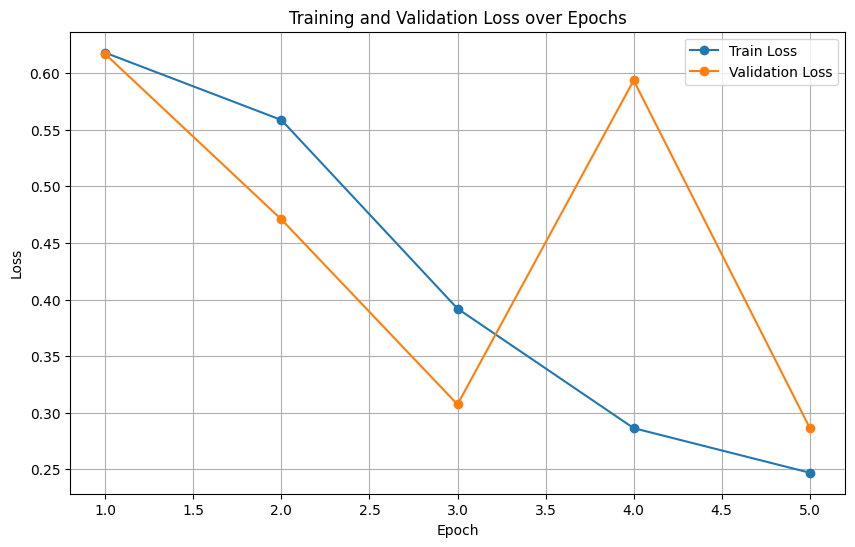

In [59]:
import matplotlib.pyplot as plt

N_EPOCHS = 5
best_valid_loss = float("inf")

# Danh sách để lưu loss và accuracy
train_losses = []
valid_losses = []

for epoch in range(N_EPOCHS):
    start_time = time.time()

    # Huấn luyện và đánh giá
    train_loss, train_acc = train(model, train_dataloader, optimizer, criterion, device)
    valid_loss, valid_acc = evaluate(model, valid_dataloader, criterion, device)

    end_time = time.time()
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    # Lưu lại train loss và validation loss
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    # Lưu model nếu valid_loss thấp nhất
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), "model_64_3l_adam.pt")

    print(f"Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s")
    print(f"\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%")
    print(f"\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%")

# Vẽ biểu đồ loss qua từng epoch
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_EPOCHS+1), train_losses, label="Train Loss", marker="o")
plt.plot(range(1, N_EPOCHS+1), valid_losses, label="Validation Loss", marker="o")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()


## Evaluation

In [61]:
INPUT_DIM = embedding_matrix.shape[0]
EMBEDDING_DIM = 100 
BATCH_SIZE = 16
HIDDEN_DIM = 256
N_LAYERS = 3
BIDIRECTIONAL = True
DROPOUT = 0.5
PAD_IDX = vocab["<pad>"]
UNK_IDX = vocab["<unk>"]

model = RNN(INPUT_DIM,
            EMBEDDING_DIM,
            HIDDEN_DIM,
            N_LAYERS,
            BIDIRECTIONAL,
            DROPOUT,
            PAD_IDX)


# Load the state_dict into the model
checkpoint = torch.load('/kaggle/input/three-layer/model_64_3l_adam.pt')
model.load_state_dict(checkpoint)

# Switch the model to evaluation model
model.eval()

# Move the model to the appropriate device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

/tmp/ipykernel_23/2398814531.py:21: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/input/three-layer/model_64_3l_adam.pt')


RNN(
  (embedding): Embedding(1585076, 100, padding_idx=0)
  (rnn): LSTM(100, 256, num_layers=3, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [62]:
test_loss, test_acc,f1_score = evaluate(model, test_dataloader, criterion, device)
print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%| F1-score: {f1_score*100:.2f}%')

Test Loss: 0.139 | Test Acc: 95.23%| F1-score: 95.26%


In [63]:
def predict_sentiment(model, sentence, vocab, device):
    model.eval()
    corpus = [sentence]
    tensor = vocab.corpus_to_tensor(corpus)[0].to(device)
    tensor = tensor.unsqueeze(1)
    length = [len(tensor)]
    length_tensor = torch.LongTensor(length)
    prediction = torch.sigmoid(model(tensor, length_tensor))
    return prediction.item()

In [64]:
sentence = "Bộ phim này rất dở!"

predict_sentiment(model, sentence, vocab, device)

Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 4401.16it/s]


0.021231913939118385

In [65]:
sentence = "Bộ phim này rất hay!"

predict_sentiment(model, sentence, vocab, device)

Tokenize the corpus...


100%|██████████| 1/1 [00:00<00:00, 4650.00it/s]


0.8963090777397156